In [8]:
import pandas as pd
import numpy as np
from collections import Counter
import geopandas as gpd
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from shapely.geometry import Point
import folium
import overpass
from textwrap import dedent
import requests
import json
from functools import lru_cache
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.compose import make_column_transformer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
import six
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

pd.options.display.max_columns = None

In [9]:
usecols = [
    "id", "name", "summary", "space", "description", "neighborhood_overview", "notes", "transit", "access", "interaction", 
    "house_rules", "host_about", "neighbourhood_cleansed", "latitude", "longitude", "property_type", "room_type", 
    "accommodates", "bathrooms", "bedrooms", "beds", "bed_type", "amenities", "security_deposit", "cleaning_fee", 
    "guests_included", "minimum_nights", "cancellation_policy", "host_response_rate"
]

train = pd.read_csv("train.csv", usecols=usecols + ["price"])
test = pd.read_csv("test.csv", usecols=usecols)
calendar = pd.read_csv("calendar.csv", parse_dates=["date"])
reviews = pd.read_csv("reviews.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [10]:
train.head(3)

,id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_about,host_response_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,guests_included,minimum_nights,cancellation_policy,price
0,127860,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...","Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...","The host (Andy) is usually in residence, but m...","While the house is a great space to entertain,...",My wife and I work in property development. S...,NaN,Richmond upon Thames,51.447147,-0.339253,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Breakfast...",300.0,10.0,1,2,strict_14_with_grace_period,1000.0
1,325809,Big House for Olympics sleeps 6 to8,NaN,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",NaN,NaN,NaN,NaN,NaN,A copy of your passports or Id cards will be r...,"Hi there,\r\n\r\nI'm a music artist manager an...",NaN,Camden,51.549993,-0.184546,House,Entire home/apt,8,2.5,3.0,4.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",771.0,NaN,1,14,strict_14_with_grace_period,771.0
2,429045,The Old Coach House (Olympics),NaN,"Fabulous, recently refurbished original Victor...","Fabulous, recently refurbished original Victor...",NaN,NaN,NaN,NaN,NaN,NaN,"I am making available a fabulous, recently ref...",NaN,Lewisham,51.469213,-0.007671,House,Entire home/apt,6,3.0,3.0,3.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",600.0,NaN,1,14,strict_14_with_grace_period,1500.0


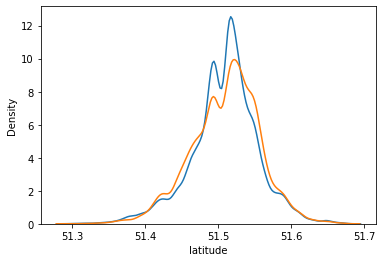

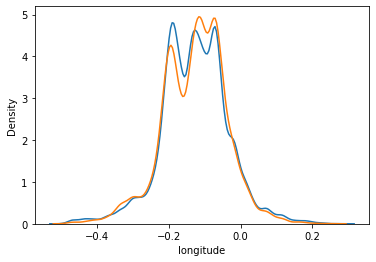

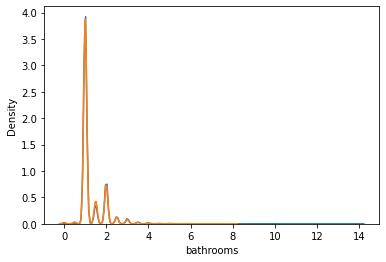

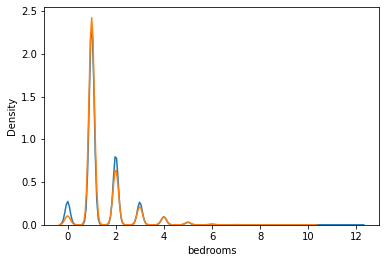

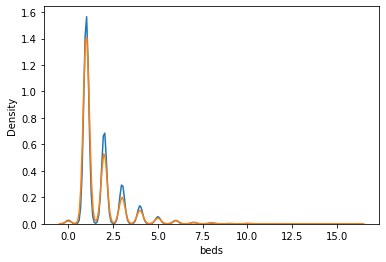

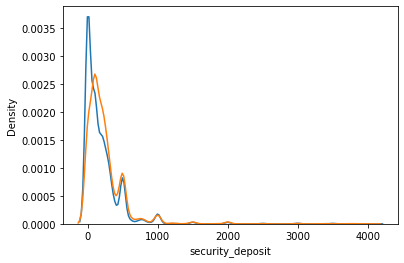

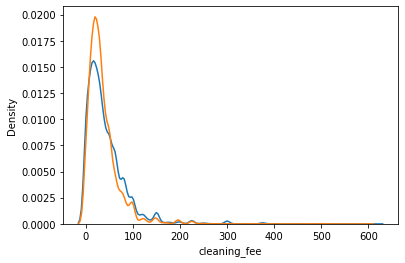

In [11]:
for feat in test.select_dtypes([int, float]).columns:
    plt.figure()
    sns.kdeplot(train[feat])
    sns.kdeplot(test[feat])
    plt.show()

In [12]:
reviews["comments"] = reviews["comments"].fillna("")
revs = reviews.groupby("listing_id")["comments"].apply(list).str.join(" ")

In [13]:
cld = calendar.loc[calendar["available"] == "t"].groupby("listing_id")["date"].count()

In [14]:
class TextProcessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def process(self, text):
        if not isinstance(text, six.string_types):
            return ""
        cleaned_text = re.sub("\W+|\d", " ", text)
        res = " ".join([self.lemmatizer.lemmatize(x).lower() for x in word_tokenize(cleaned_text)])
        return res
    
    def process_series(self, text_series):
        return text_series.apply(self.process)

In [17]:
class AirbnbDataset(TextProcessor):
    TEXT_FEATURES = [
        "name", "summary", "space", "description", "neighborhood_overview", "notes", "transit", "access", 
        "interaction", "house_rules", "host_about", "amenities", "comments"
    ]
    OTH_FEATURES = [
        "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", 
        "bed_type", "guests_included", "minimum_nights", "cancellation_policy",
        "amenities_number", "beds_per_bedroom", "date", "location", "host_response_rate",
        "amenity", "leisure"
        # , "cleaning_fee" , "security_deposit"
        # "latitude", "longitude", 
    ]
    CAT_FEATURES = ["property_type", "room_type", "bed_type", "location"]
    
    @staticmethod
    def _room_type(df):
        df["room_type"] = df["room_type"].map({"Entire home/apt": 2, "Private room": 1, "Shared room": 0})
        
    @staticmethod
    def _cancellation_policy(df):
        df["cancellation_policy"] = df["cancellation_policy"].map({
            'flexible': 0,
            'moderate': 1,
            'strict_14_with_grace_period': 2,
            'strict': 3,
            'super_strict_30': 4,
            'super_strict_60': 5
        })
        
    @staticmethod
    def _amenities_number(df):
        df["amenities_number"] = df["amenities"].str.strip(r"{}").str.split(",").apply(len).replace(0, np.nan)
    
    @staticmethod
    def _beds_per_bedroom(df):
        df["beds_per_bedroom"] = (df["bedrooms"] / df["beds"]).replace([np.inf, -np.inf, np.nan], 0)
        
    @staticmethod
    def _host_response_rate(df):
        df["host_response_rate"] = df["host_response_rate"].str.replace("%", "").astype(float)
        
    @staticmethod
    def count_poi_helper(latitude, longitude, *, search_string, radius=1000, retries=5):
        query = dedent(
            f"""
            [out:json];
            node[~"^{search_string}"~"."](around:{radius},{latitude},{longitude});
            out count;
            """
        )
        try:
            response = requests.post("https://overpass-api.de/api/interpreter", data=query)
            data = response.json()
            total = int(data["elements"][0]["tags"]["total"])
            return total
        except ValueError:
            retries -= 1
            if retries:
                return AirbnbDataset.count_poi_helper(latitude, longitude, search_string=search_string, radius=radius, retries=retries)
            return np.nan
            
    @staticmethod
    @lru_cache(maxsize=10**4)
    def count_poi(latitude, longitude, *, search_string="^(amenity|leisure)$", radius=1000):
        return AirbnbDataset.count_poi_helper(latitude, longitude, search_string=search_string, radius=radius)
    
    @classmethod
    def make_features(cls, Xy_train, X_test):
        Xy_train_ = Xy_train.copy()
        X_test_ = X_test.copy()
        
        Xy_train_ = Xy_train_.merge(revs, left_on="id", right_index=True, how="left")
        X_test_ = X_test_.merge(revs, left_on="id", right_index=True, how="left")
        
        Xy_train_ = Xy_train_.merge(cld, left_on="id", right_index=True, how="left")
        X_test_ = X_test_.merge(cld, left_on="id", right_index=True, how="left")
        
        AirbnbDataset._amenities_number(Xy_train_)
        AirbnbDataset._amenities_number(X_test_)
        
        AirbnbDataset._cancellation_policy(Xy_train_)
        AirbnbDataset._cancellation_policy(X_test_)
        
        AirbnbDataset._amenities_number(Xy_train_)
        AirbnbDataset._amenities_number(X_test_)
        
        AirbnbDataset._host_response_rate(Xy_train_)
        AirbnbDataset._host_response_rate(X_test_)
        
        X_test_["bathrooms"] = X_test_["bathrooms"].fillna(X_test_["bathrooms"].mean())
        X_test_["bedrooms"] = X_test_["bedrooms"].fillna(X_test_["bedrooms"].mean())
        X_test_["beds"] = X_test_["bedrooms"].fillna(X_test_["beds"].mean())
        
        AirbnbDataset._beds_per_bedroom(Xy_train_)
        AirbnbDataset._beds_per_bedroom(X_test_)
        
                        
        kmeans = KMeans(n_clusters=100)
        Xy_train_["location"] = kmeans.fit_predict(Xy_train_[["latitude", "longitude"]])
        X_test_["location"] = kmeans.predict(X_test_[["latitude", "longitude"]])      
        
        centroids_train = pd.DataFrame(
            kmeans.cluster_centers_[kmeans.predict(Xy_train_[["latitude", "longitude"]])], 
            columns=["c_latitude", "c_longitude"]
        )
        
        Xy_train_["amenity"] = centroids_train.apply(lambda x: AirbnbDataset.count_poi(*x, search_string="amenity"), axis=1)
        Xy_train_["leisure"] = centroids_train.apply(lambda x: AirbnbDataset.count_poi(*x, search_string="leisure"), axis=1)
        
        centroids_test = pd.DataFrame(
            kmeans.cluster_centers_[kmeans.predict(X_test_[["latitude", "longitude"]])], 
            columns=["c_latitude", "c_longitude"]
        )
        X_test_["amenity"] = centroids_test.apply(lambda x: AirbnbDataset.count_poi(*x, search_string="amenity"), axis=1)
        X_test_["leisure"] = centroids_test.apply(lambda x: AirbnbDataset.count_poi(*x, search_string="leisure"), axis=1)
        
        tp = TextProcessor()
        for feat in cls.TEXT_FEATURES:
            Xy_train_[feat] = tp.process_series(Xy_train_[feat])
            X_test_[feat] = tp.process_series(X_test_[feat])
        
        vectorizers = [(TfidfVectorizer(max_features=10000, lowercase=False), feat) for feat in cls.TEXT_FEATURES]
        column_transformer = make_column_transformer(*vectorizers)
        pipeline = Pipeline([
            ("text", column_transformer),
            ("svd", TruncatedSVD(n_components=2000))
        ])

        
        X_train_part1 = pd.DataFrame(
            pipeline.fit_transform(Xy_train_[cls.TEXT_FEATURES])
        )
        X_test_part1 = pd.DataFrame(
            pipeline.transform(X_test_[cls.TEXT_FEATURES])
        )
        
        X_train_part2 = Xy_train_[cls.OTH_FEATURES]
        X_test_part2 = X_test_[cls.OTH_FEATURES]
        
        X_trn = pd.concat([X_train_part1, X_train_part2], axis=1)
        X_tst = pd.concat([X_test_part1, X_test_part2], axis=1)
        
        for feat in cls.CAT_FEATURES:
            X_trn[feat] = pd.Series(X_trn[feat], dtype="category")
            X_tst[feat] = pd.Series(X_tst[feat], dtype="category")
        
        y_trn = Xy_train_["price"]
        
        return X_trn, y_trn, X_tst

In [18]:
%%time
X_train, y_train, X_test = AirbnbDataset().make_features(train, test)

Wall time: 23min 8s


In [26]:
regressor = lgb.LGBMRegressor()

In [27]:
regressor.fit(X_train, np.log(y_train + 0.0001))

LGBMRegressor()

In [28]:
sample_submission["price"] = np.exp(regressor.predict(X_test)) - 0.0001

In [29]:
sample_submission["price"].describe()

count    23000.000000
mean        89.135732
std         62.963915
min         10.748956
25%         44.160259
50%         69.146905
75%        114.191416
max        658.838127
Name: price, dtype: float64

In [ ]:
sample_submission.to_csv("submission.csv", index=False)